In [1]:
import os
import sys
import pandas as pd
#import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
# Build an absolute path from this notebook's parent directory
module_path = os.path.abspath(os.path.join('..', 'src'))
print(module_path)
# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)
# Now you can import the desired function or class
from graph_helpers import *
from helpers import *
from plots import *
from geopy.distance import geodesic
from find_net_stats import *
from graph_save_run import *
from spatial_helpers import *

/nfs/nfs9/home/nobackup/vakrao/nz_model/src
/nfs/nfs9/home/nobackup/vakrao/nz_model/src


Three Ways to think about spatial spread of disease


    1. How far outbreak reaches from a single seed. First set of hisotgram shows the distribution of long-distance spread
    2. Measuring the distance from the closest infected farm. 
    3. Meausing how far away the transmitting farm was? This feels difficult since many

In [56]:
#Create graph of all nodes
# now, filter for best fits 
# month best fit: (.04,.1,33297)
# seas best fit: (.03,.08,21709)
# year best fit: (.08,.04,21906)
netfile = "../params/horticulture365_check_NZ.csv"
inc_fp  = "../params/window_psa.csv"
prop_fp = "../params/2024_prop_dat.csv"
post_fp = "temp_post.csv"
in_bond,out_bond = read_network_data(netfile)
prop_size = read_property_data(prop_fp)
m_bb,m_bw,m_s = .03,.09,["8878"]
s_bb,s_bw,s_s = .03,.08,["21729"]
y_bb,y_bw,y_s = .04,.07,["10322"]
D_m,D_s,D_y = 0.4,0.8,0.8
L = 3
T = 425+92
max_infected = 3000
deltaT = 3
min_inc = 1
alpha = 0.1
F = 625
cal_month = 11
t,m_id,m_i = run_save_si_model(in_bond,out_bond,prop_size,m_bb,m_bw,D_m,m_s,T,max_infected,1,min_inc,alpha,F,cal_month)
t,s_id,s_i = run_save_si_model(in_bond,out_bond,prop_size,s_bb,s_bw,D_s,s_s,T,max_infected,3,min_inc,alpha,F,cal_month)
#t,y_id,y_i = run_save_si_model(in_bond,out_bond,prop_size,y_bb,y_bw,D_y,y_s,T,max_infected,12,min_inc,alpha,F,cal_month)


In [57]:
#lets do the ccdf for yearly first
from scipy import stats
def calc_dist_from_pair(in_bond,prop_dat,t=False):
    proper_loc = dict(zip(prop_dat["PROPERTY_ID"], zip(
        prop_dat["GPS_CENTRE_LONGITUDE"],  # lat
        prop_dat["GPS_CENTRE_LATITUDE"]    # lon
    )))
    country = dict(zip(prop_dat["PROPERTY_ID"],prop_dat["COUNTRY"]))
    all_dist = []
    for k in in_bond:
        all_connect = in_bond[k]
        k_loc = proper_loc[int(k)]
        for i in all_connect:
            i_loc = proper_loc[int(i)]
            pair_dist = round(geodesic(k_loc,i_loc).km,1)
          #  if pair_dist > 100 :
           #     pair_dist = 100
            if t == False:
                all_dist.append(pair_dist)
            if t == True:
                for z in range(0,int(all_connect[i])):
                    all_dist.append(pair_dist)
        
    return all_dist
def find_cdf(in_bond,prop_dat,t=False,plot_all=False):
    year_dist = calc_dist_from_pair(in_bond,prop_dat,t)
    year_dist = sorted(year_dist)
    year_unq = {}
    for y in year_dist:
        if y not in year_unq:
            year_unq[y] = 1
        else:
            year_unq[y] += 1
    year_cdf = []
    total = 0
    cdf_dict = {}
    for y in year_unq:
        total += year_unq[y]
        year_cdf.append(total)
    year_cdf = [(1-(y/total)) for y in year_cdf]
    x_year = list(year_unq.keys())
    all_vals = list(zip(x_year,year_cdf))
    for a in all_vals:
        dist_val = a[0]
        cdf_val = a[1]
    #if plot_all == False:
    #    year_cdf.pop(-1)
    #    x_year.pop(-1)
    return x_year,year_cdf 

def observe_movement(in_bond,prop_dat,t=True):
    year_dist = calc_dist_from_pair(in_bond,prop_dat,t)
    year_dist = sorted(year_dist)
    year_unq = {}
    tm_amount = 0
    for y in year_dist:
        round_dist = int(y)
        if y not in year_unq:
            year_unq[round_dist] = 1
        else:
            year_unq[round_dist] += 1
        tm_amount += 1
    move_amount = [i for i in range(0,1000)]
    move_dict = {}
    for m in move_amount:
        m_count = 0
        if m in year_unq:
            m_count = year_unq[m]
        move_dict[m] = m_count
    return move_dict

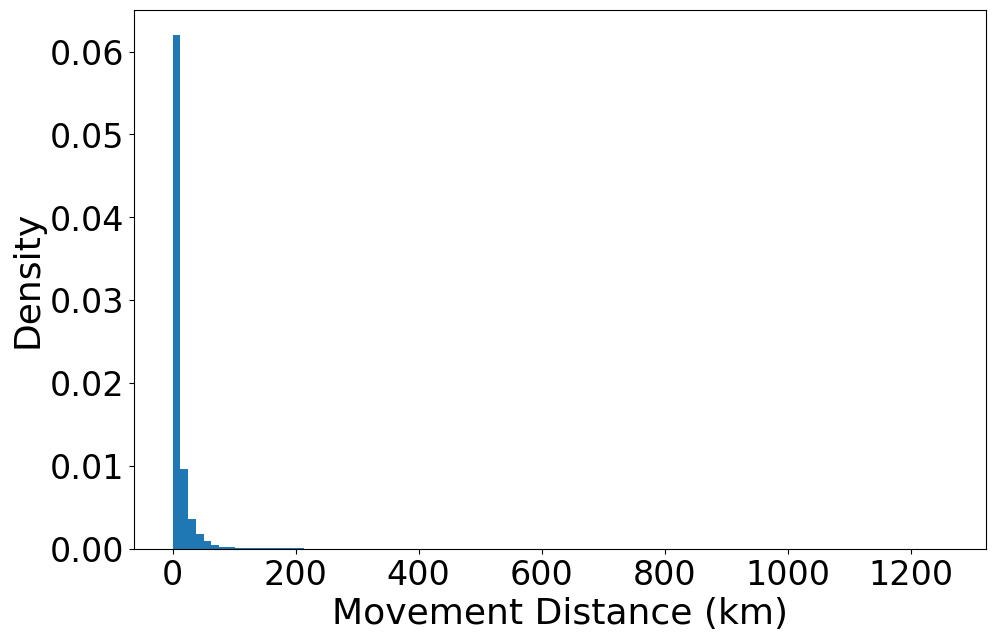

In [4]:
fig,axs = plt.subplots(figsize=(11, 7))
prop_dat = pd.read_csv(prop_fp)
#print(in_bond)
year_dist = calc_dist_from_pair(in_bond,prop_dat,t=True)
#year_dist = sorted(year_dist)
axs.hist(year_dist,density=True,bins=100)
#m_dict = observe_movement(in_bond,prop_dat)
#x_m,y_m = list(m_dict.keys()),list(m_dict.values())
#axs.plot(x_m,y_m,label="Yearly",color="#377eb8")
#axs.set_yscale('log')
#axs.set_xscale('log')
#axs.legend(fontsize=24)
axs.set_xlabel("Movement Distance (km)",fontsize=26)
axs.set_ylabel("Density",fontsize=26)
axs.tick_params(labelsize=24)
#plt.xticks([0,20,40,60,80,100],["0","20","40","60","80",">=100"])
fig.savefig("figs/year_density.png")

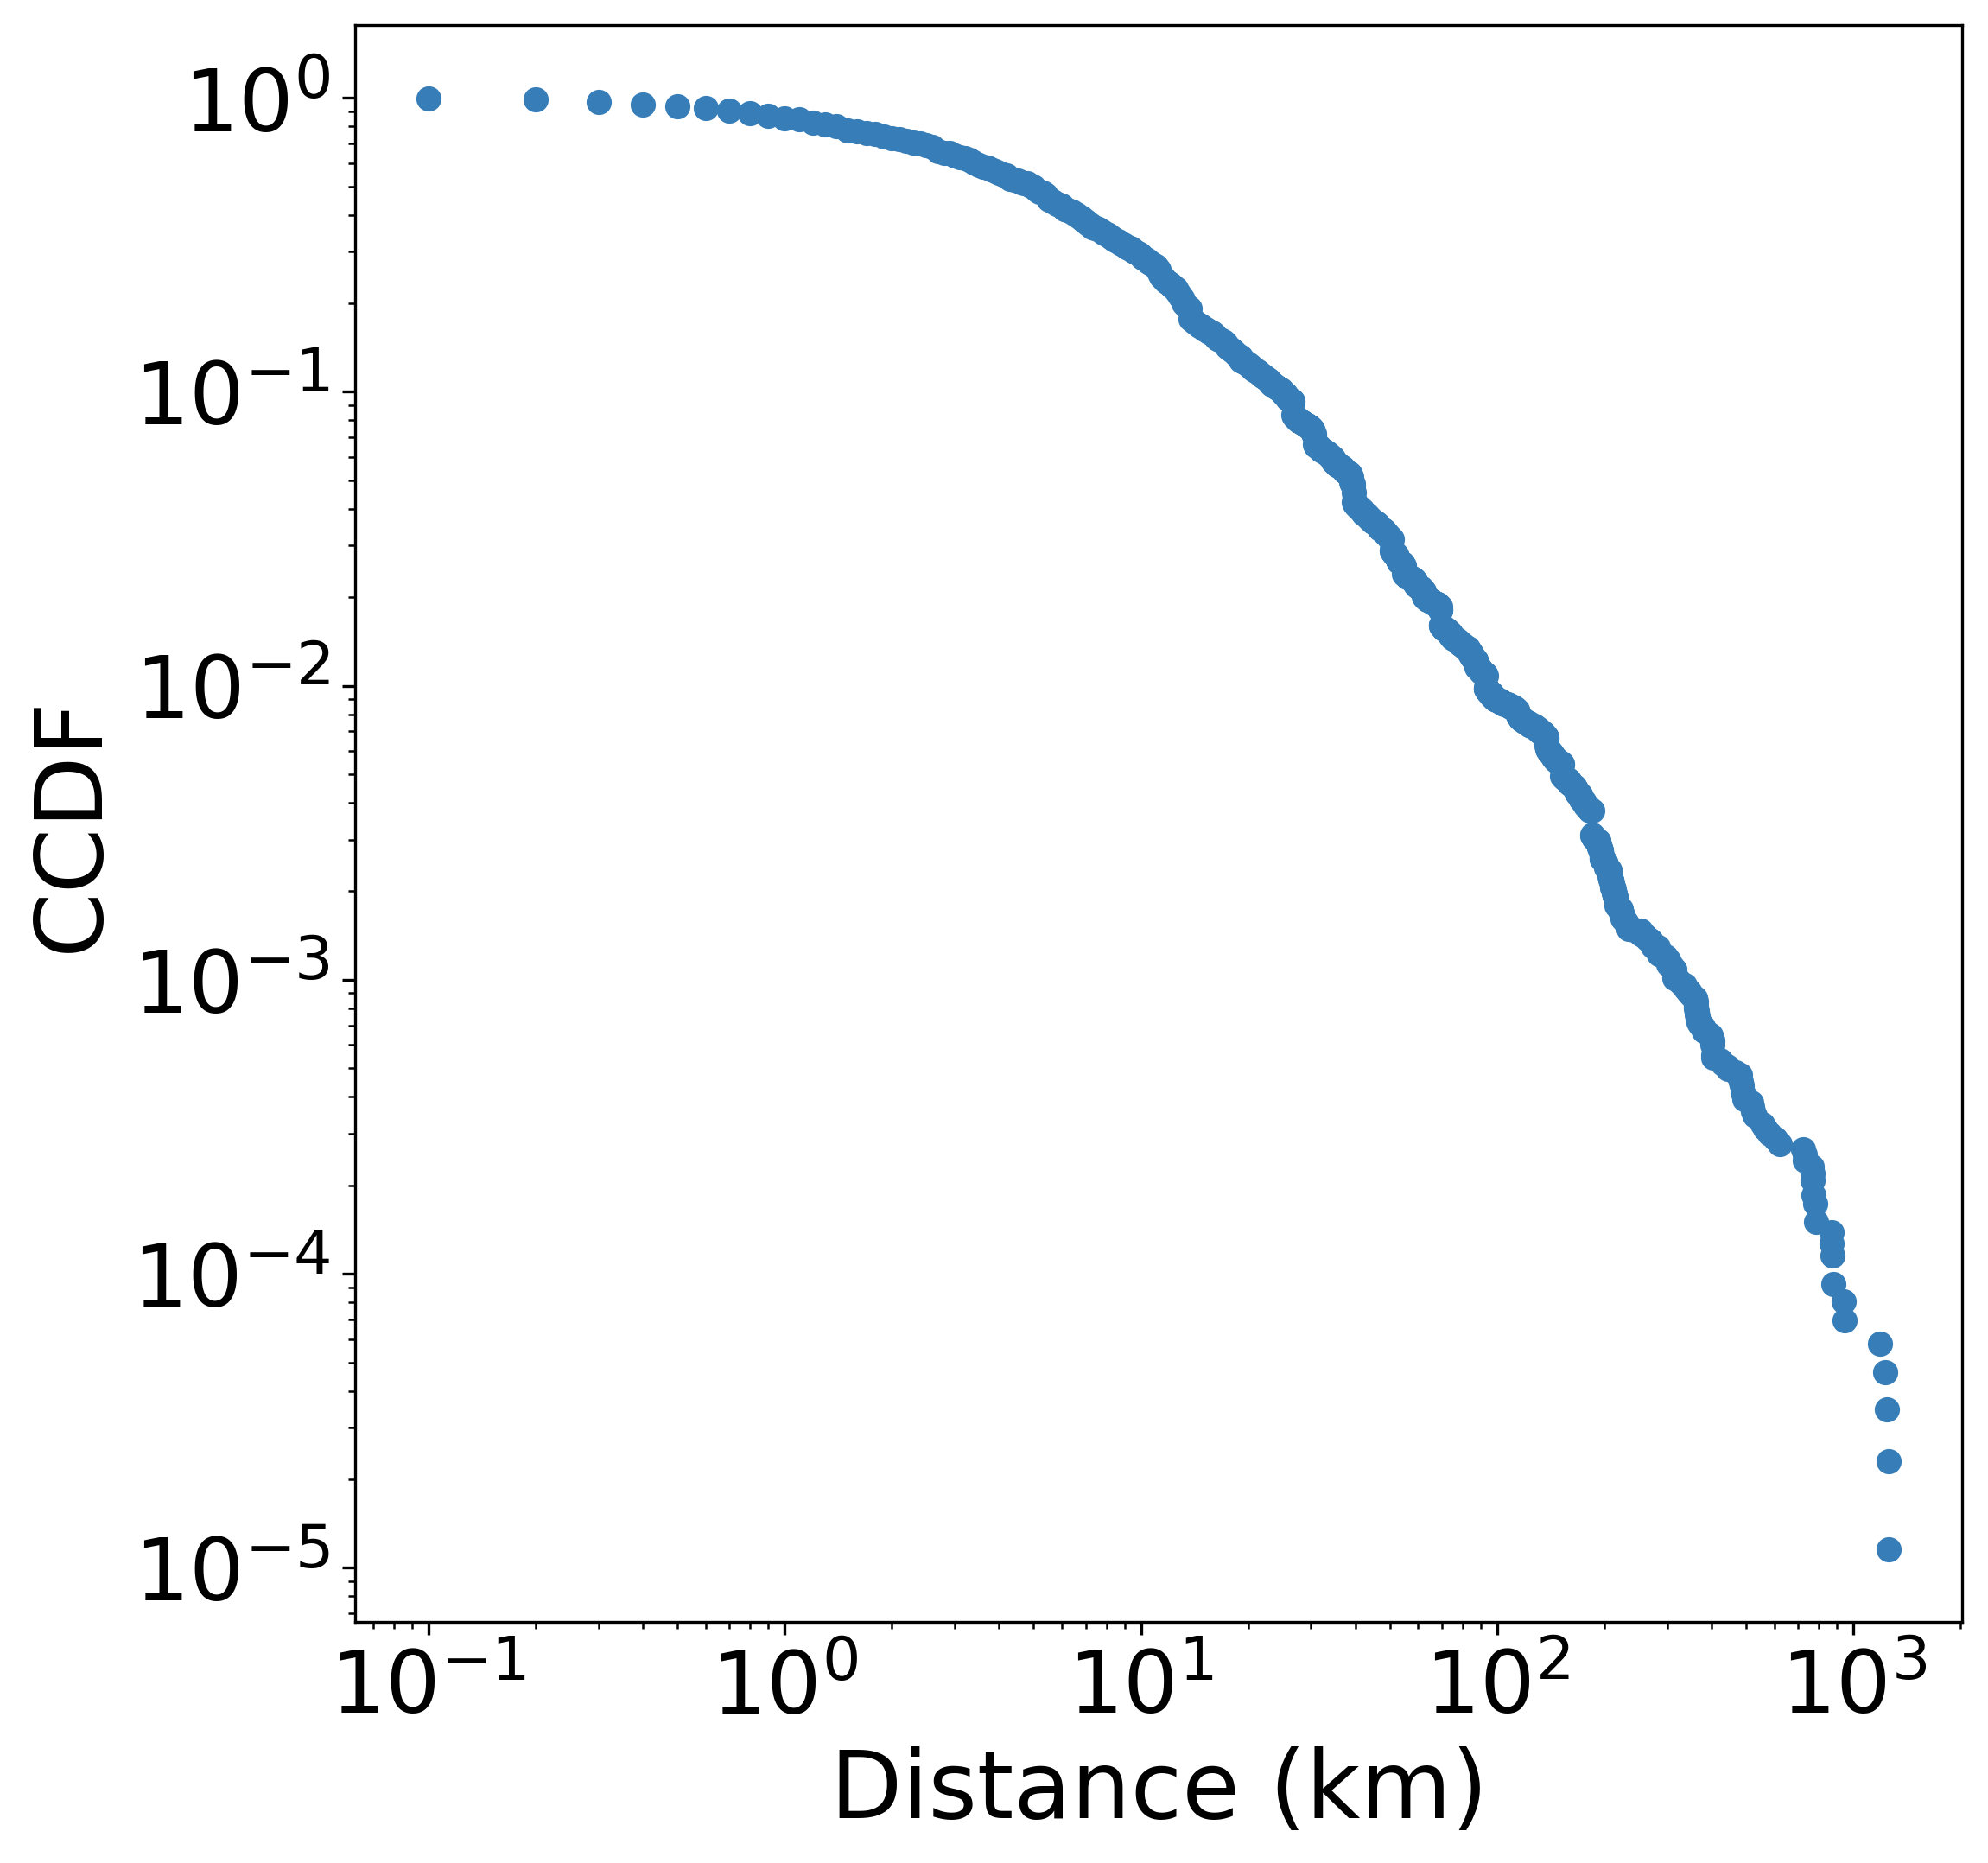

In [5]:
fig,axs = plt.subplots(figsize=(8, 8), dpi=300)
prop_dat = pd.read_csv(prop_fp)

x_wy,y_wcdf = find_cdf(in_bond,prop_dat,True)
axs.scatter(x_wy,y_wcdf,label="Yearly",color="#377eb8")
axs.set_yscale('log')
axs.set_xscale('log')
#axs.legend(fontsize=24)
axs.set_xlabel("Distance (km)",fontsize=26)
axs.set_ylabel("CCDF",fontsize=26)
axs.tick_params(labelsize=24)
#plt.xticks([0,20,40,60,80,100],["0","20","40","60","80",">=100"])
fig.savefig("figs/log_cdf.png")

In [6]:

def calc_dist_from_seed(infec_dict,s):
    prop_dat = pd.read_csv(prop_fp)
    proper_loc = dict(zip(prop_dat["PROPERTY_ID"], zip(
        prop_dat["GPS_CENTRE_LONGITUDE"],  # lat
        prop_dat["GPS_CENTRE_LATITUDE"]    # lon
    )))
    country = dict(zip(prop_dat["PROPERTY_ID"],prop_dat["COUNTRY"]))
    seed_loc = proper_loc[s]
    all_dist = []
    for infected_prop_id in infec_dict:
        if int(infected_prop_id) != int(s):
            infected_prop_loc = proper_loc[int(infected_prop_id)]
            trans_dist = geodesic(seed_loc,infected_prop_loc).km
            all_dist.append(trans_dist)
    return all_dist
def calc_min_prox(infec_dict,s):
    prop_dat = pd.read_csv(prop_fp)
    proper_loc = dict(zip(prop_dat["PROPERTY_ID"], zip(
        prop_dat["GPS_CENTRE_LONGITUDE"],  # lat
        prop_dat["GPS_CENTRE_LATITUDE"]    # lon
    )))
    country = dict(zip(prop_dat["PROPERTY_ID"],prop_dat["COUNTRY"]))
    seed_loc = proper_loc[s]
    all_dist = []
    prev_infected = {}
    for node in infec_dict:
        infec_time = infec_dict[node]
        if infec_time not in prev_infected:
            prev_infected[infec_time]= [node]
        else:
            prev_infected[infec_time].append(node)
    for infected_prop_id in infec_dict:
        infec_time = infec_dict[infected_prop_id]
        curr_prop_loc = proper_loc[int(infected_prop_id)]
        min_dist = np.inf
        prev_prop_loc = 0
        # go through all previous infected nodes
        # find the smallest distnace based on previous infected nodes
        if int(infected_prop_id) == int(s):
            min_dist = 0
        for t in prev_infected: 
            if t <= infec_time:
                prev_infec_nodes = prev_infected[t]
                close_loc = 0
                for p in prev_infec_nodes:
                    if int(p) != int(infected_prop_id):
                        prev_prop_loc = proper_loc[int(p)]
                        trans_dist = geodesic(curr_prop_loc,prev_prop_loc).km
                        if trans_dist < min_dist:
                            min_dist = trans_dist
                            close_loc = prev_prop_loc
        all_dist.append(min_dist)
    return all_dist
def calc_max_prox(infec_dict,s):
    prop_dat = pd.read_csv(prop_fp)
    proper_loc = dict(zip(prop_dat["PROPERTY_ID"], zip(
        prop_dat["GPS_CENTRE_LONGITUDE"],  # lat
        prop_dat["GPS_CENTRE_LATITUDE"]    # lon
    )))
    seed_loc = proper_loc[s]
    all_dist = []
    prev_infected = {}
    # get time when infection is detected
    for node in infec_dict:
        infec_time = infec_dict[node]
        if infec_time not in prev_infected:
            prev_infected[infec_time]= [node]
        else:
            prev_infected[infec_time].append(node)
    # go through infected dictionary
    for infected_prop_id in infec_dict:
        infec_time = infec_dict[infected_prop_id]
        #print(infec_time)
        curr_prop_loc = proper_loc[int(infected_prop_id)]
        max_dist = 0
        prev_prop_loc = 0
        # go through all previous infected nodes
        # find the largest distance between a node and a 
        # previously infected node
        if int(infected_prop_id) == int(s):
            max_dist = 0
        for t in prev_infected:
          #  print(t)
            if t <= infec_time:
                prev_infec_nodes = prev_infected[t]
               # print("previosuly infected nodes: ",prev_infec_nodes)
                close_loc = 0
                for p in prev_infec_nodes:
                  #  print("previously infected nodes: ",prev_infec_nodes)
                   # print("p value: ",p)
                    if int(p) != int(infected_prop_id):
                        prev_prop_loc = proper_loc[int(p)]
                        trans_dist = geodesic(curr_prop_loc,prev_prop_loc).km
                      #  print("distance: ",trans_dist)
                        if trans_dist > max_dist:
                            max_dist = trans_dist
                            close_loc = prev_prop_loc
            else:
                break
        all_dist.append(max_dist)
    return all_dist


def seed_distance(infec_dict,s):
    prop_dat = pd.read_csv(prop_fp)
    proper_loc = dict(zip(prop_dat["PROPERTY_ID"], zip(
        prop_dat["GPS_CENTRE_LONGITUDE"],  # lat
        prop_dat["GPS_CENTRE_LATITUDE"]    # lon
    )))
    seed_loc = proper_loc[s]
    all_dist,all_time = [],[]
    prev_infected = {}
    less_val = 0
    total = 0
    # get time when infection is detected
    for node in infec_dict:
        infec_time = infec_dict[node]
        infec_loc = proper_loc[int(node)]
        trans_dist = geodesic(seed_loc,infec_loc).km
        all_dist.append(trans_dist)
        all_time.append(infec_time)
        if trans_dist < 200:
            less_val += 1
        total+= 1
    print(" < 250: ",less_val/total)
    return all_dist,all_time

 < 250:  0.7452907452907452


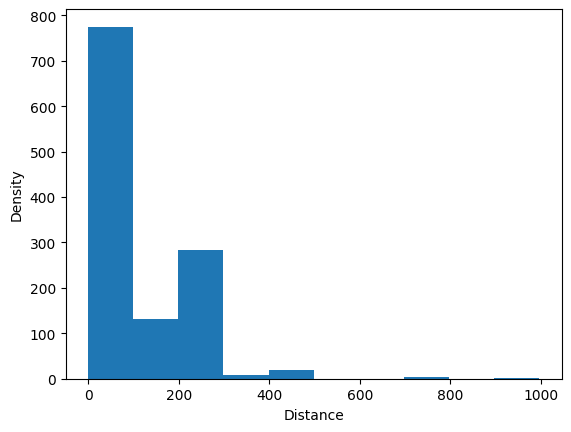

In [54]:
seed_dist,seed_time = seed_distance(s_id,int(s_s[0]))
min_dist = calc_min_prox(s_id,int(s_s[0]))
max_dist = calc_max_prox(s_id,int(s_s[0]))
avg_dist = calc_avg_prox(s_id,in_bond,prop_fp,int(s_s[0]))
#year_dist = calc_min_prox(y_id,int(y_s[0]))
#month_dist = calc_min_prox(m_id,int(m_s[0]))
plt.hist(seed_dist)
plt.xlabel("Distance")
plt.ylabel("Density")
plt.savefig("figs/hist_distance.png")

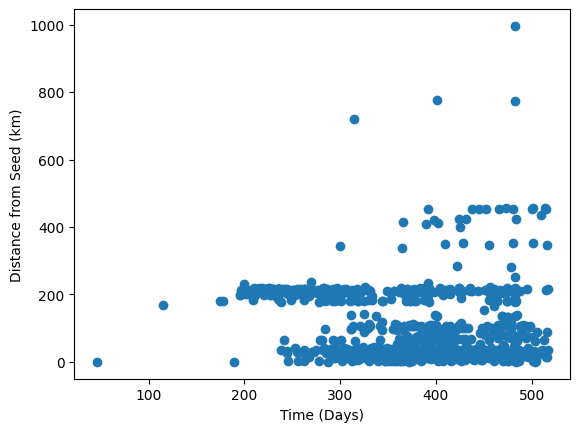

In [50]:
plt.scatter(seed_time,seed_dist)
plt.xlabel("Time (Days)")
plt.ylabel("Distance from Seed (km)")
plt.savefig("figs/source_distance.png")

In [8]:
"""
dist_bins = [i for i in range(0,1000,100)]
bars = ["0-10","10-20",">20"]
title_fs = 20
bar_x,bar_y = 17,8
fig,axs = plt.subplots(1,1,figsize=(bar_x,bar_y),constrained_layout=True)
m_val,s_val,y_val = [0,0,0],[0,0,0],[0,0,0]
colors = ["#377eb8","#ff7f00","#4daf4a"]

for s in seas_dist:
    if s < 10:
        s_val[0] += 1
    if s >= 10 and s < 20:
        s_val[1] += 1
    if s > 20:
        s_val[2] += 1
for m in month_dist:
    if m < 10:
        m_val[0] += 1
    if m >= 10 and m < 20:
        m_val[1] += 1
    if m > 20:
        m_val[2] += 1
for y in year_dist:
    if y < 10:
        y_val[0] += 1
    if y >= 10 and y < 20:
        y_val[1] += 1
    if y > 20:
        y_val[2] += 1
for i in range(0,len(bars)):
    s_val[i] = s_val[i]/len(seas_dist)
    m_val[i] = m_val[i]/len(month_dist)
    y_val[i] = y_val[i]/len(year_dist)
        
axs[0].bar(bars,y_val,alpha=0.6,label="Year",color=colors[0])
axs[1].bar(bars,s_val,alpha=0.6,label="Season",color=colors[1])
axs[2].bar(bars,m_val,alpha=0.6,label="Month",color=colors[2])
tick_fs = 28
title_fs = 30
axs[0].tick_params(labelsize=tick_fs)
axs[1].tick_params(labelsize=tick_fs)
axs[2].tick_params(labelsize=tick_fs)
axs[0].set_title(label="Yearly",fontsize=title_fs)
axs[1].set_title(label="Seasonal",fontsize=title_fs)
axs[2].set_title(label="Monthly",fontsize=title_fs)
axs[0].annotate("(A)",(1,.6),fontsize=24)
axs[1].annotate("(B)",(1,.6),fontsize=24)
axs[2].annotate("(C)",(1,.6),fontsize=24)
fig.tight_layout()
print(list(zip(bars,y_val)))
print(list(zip(bars,s_val)))
print(list(zip(bars,m_val)))
x_lab = fig.supxlabel("Distance (km)",size=30)
x_lab.set_position((0.5, -0.05))
fig.savefig("figs/prox_bars.png",dpi=300, bbox_inches='tight')
"""

'\ndist_bins = [i for i in range(0,1000,100)]\nbars = ["0-10","10-20",">20"]\ntitle_fs = 20\nbar_x,bar_y = 17,8\nfig,axs = plt.subplots(1,1,figsize=(bar_x,bar_y),constrained_layout=True)\nm_val,s_val,y_val = [0,0,0],[0,0,0],[0,0,0]\ncolors = ["#377eb8","#ff7f00","#4daf4a"]\n\nfor s in seas_dist:\n    if s < 10:\n        s_val[0] += 1\n    if s >= 10 and s < 20:\n        s_val[1] += 1\n    if s > 20:\n        s_val[2] += 1\nfor m in month_dist:\n    if m < 10:\n        m_val[0] += 1\n    if m >= 10 and m < 20:\n        m_val[1] += 1\n    if m > 20:\n        m_val[2] += 1\nfor y in year_dist:\n    if y < 10:\n        y_val[0] += 1\n    if y >= 10 and y < 20:\n        y_val[1] += 1\n    if y > 20:\n        y_val[2] += 1\nfor i in range(0,len(bars)):\n    s_val[i] = s_val[i]/len(seas_dist)\n    m_val[i] = m_val[i]/len(month_dist)\n    y_val[i] = y_val[i]/len(year_dist)\n        \naxs[0].bar(bars,y_val,alpha=0.6,label="Year",color=colors[0])\naxs[1].bar(bars,s_val,alpha=0.6,label="Season",c

In [16]:
## daily, what is the largest distance between two infected properties 
graph_type = "max"
s_max,s_a = calc_monthly_spread(s_id,prop_fp,graph_type,int(s_s[0]))
#y_m,y_a = calc_monthly_spread(y_id,prop_fp,graph_type,int(y_s[0]))
m_max,m_a = calc_monthly_spread(m_id,prop_fp,graph_type,int(m_s[0]))
#y_m = y_m[3:]
s_max = s_max[3:]
m_m = m_m[3:]
graph_type = "min"
s_min,_ = calc_monthly_spread(s_id,prop_fp,graph_type,int(s_s[0]))
m_min,_ = calc_monthly_spread(m_id,prop_fp,graph_type,int(m_s[0]))

graph_type = "avg"
_,s_avg = calc_monthly_spread(s_id,prop_fp,graph_type,int(s_s[0]))
m_avg,_ = calc_monthly_spread(m_id,prop_fp,graph_type,int(m_s[0]))

s_min = s_min[3:]
s_avg = s_avg[3:]
m_min = m_min[3:]
m_avg = m_avg[3:]
m_max = m_max[3:]

In [11]:
s_min[0] = 0
print(s_avg)

[0, 0, 0, 0, 0, 7.335087979289093, 35.570613044279, 53.59408910835558, 86.25136065468392, 131.20304479536776, 118.89994890105025, 98.83742568946538, 98.6348993377817, 120.39550744617429, 121.67678333894068, 142.83424379285955, 218.437549841437]


[1000000, 0, 7.335087979289093, 0.5341991168712924, 0.16527749482656698, 0.332570984298414, 0.08955218824925243, 0.280585101499271, 0.13749170890630005, 0.1453699008037082, 0.19950545131825165, 0.08666711556196358, 0.201015051534133, 0.2539150938750641]


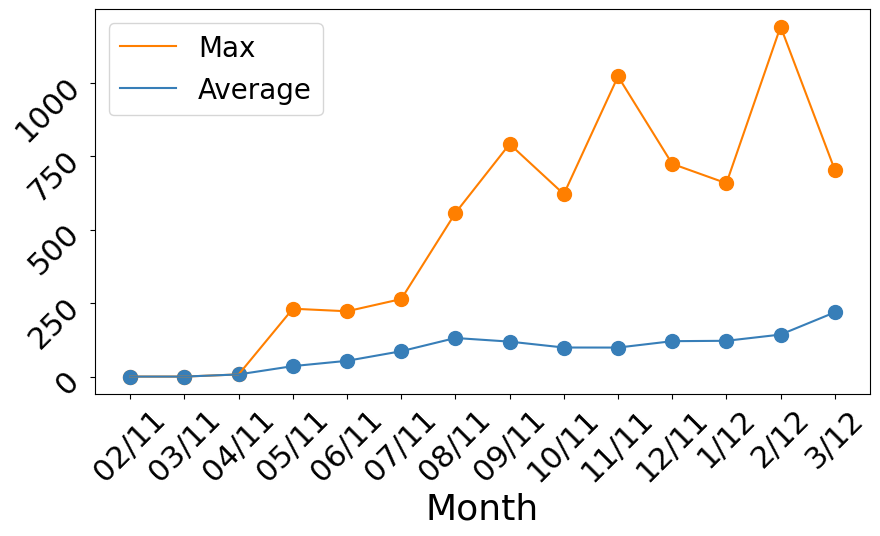

In [19]:
#f,axs = fig.subplots(1,3,figsize=(20,10))
#s_avg = s_avg[3:]
fig,axs = plt.subplots(1,1,figsize=(10,5))
x_vals = [i for i in range(0,len(s_m))]
x_vals = ["02/11","03/11","04/11","05/11","06/11","07/11","08/11","09/11","10/11","11/11","12/11","1/12","2/12","3/12"]
ms = 100
print(s_min)
axs.scatter(x_vals,s_max,color=colors[1],s=ms)
axs.plot(x_vals,s_max,color=colors[1],label="Max")
axs.scatter(x_vals,s_avg,color=colors[0],s=ms)
axs.plot(x_vals,s_avg,color=colors[0],label="Average")
axs.tick_params(labelsize=22,rotation=45)
# plot average distance
if graph_type == "min":
    axs.set_ylabel("Min Monthly Distance",size=26)
axs.set_xlabel("Month",size=26)
axs.legend(fontsize=20)
fig.savefig("figs/all_dist.png",dpi=300, bbox_inches='tight')

/tmp/ipykernel_4012185/1495083845.py:36: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


[1000000, 0, 7.335087979289093, 0.5341991168712924, 0.16527749482656698, 0.332570984298414, 0.08955218824925243, 0.280585101499271, 0.13749170890630005, 0.1453699008037082, 0.19950545131825165, 0.08666711556196358, 0.201015051534133, 0.2539150938750641]


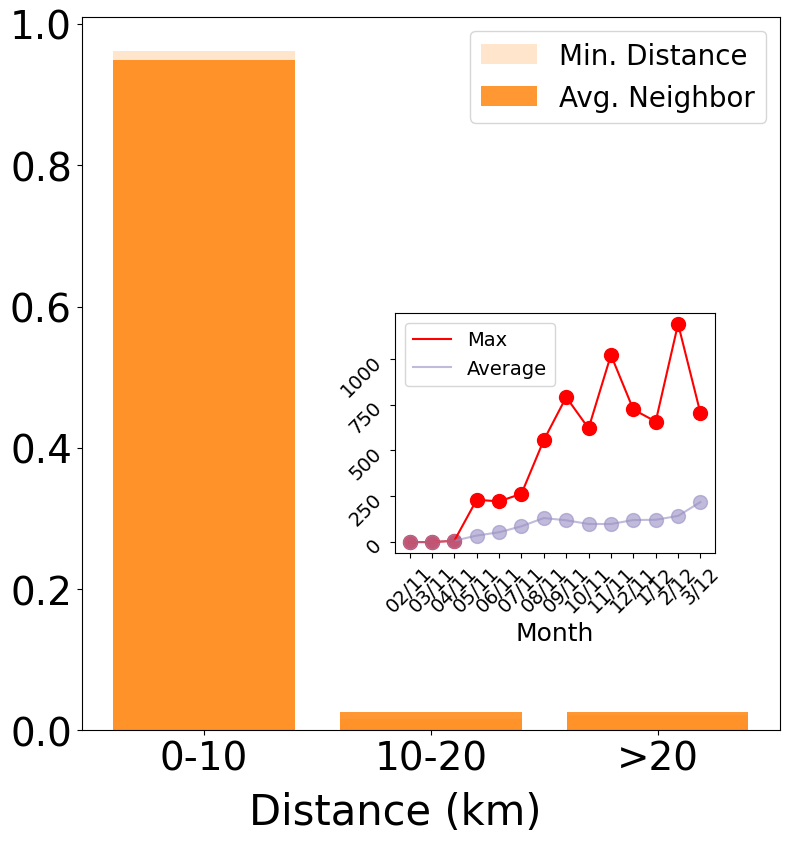

In [47]:
dist_bins = [i for i in range(0,1000,100)]
bars = ["0-10","10-20",">20"]
title_fs = 20
bar_x,bar_y = 8,8
fig,axs = plt.subplots(1,1,figsize=(bar_x,bar_y),constrained_layout=True)
avg_val,min_val = [0,0,0],[0,0,0]
colors = ["#377eb8","#ff7f00","#4daf4a"]
for s in avg_dist:
    if s < 10:
        avg_val[0] += 1
    if s >= 10 and s < 20:
        avg_val[1] += 1
    if s > 20:
        avg_val[2] += 1
for s in min_dist:
    if s < 10:
        min_val[0] += 1
    if s >= 10 and s < 20:
        min_val[1] += 1
    if s > 20:
        min_val[2] += 1

for i in range(0,len(bars)):
    avg_val[i] = avg_val[i]/len(avg_dist)
    min_val[i] = min_val[i]/len(min_dist)

avg_color = "#d95f0e"
axs.bar(bars,min_val,alpha=0.2,label="Min. Distance",color=colors[1])
axs.bar(bars,avg_val,alpha=0.8,label="Avg. Neighbor",color=colors[1])

tick_fs = 28
title_fs = 30
axs.tick_params(labelsize=tick_fs)
axs.legend(fontsize=20)
#axs.set_title(label="Seasonal",fontsize=title_fs)
fig.tight_layout()
x_lab = fig.supxlabel("Distance (km)",size=30)
x_lab.set_position((0.5, -0.05))
ins_ax = fig.add_axes([0.5, .3, .4, .3])  # [x, y, width, height] w.r.t. fig
x_vals = [i for i in range(0,len(s_m))]
x_vals = ["02/11","03/11","04/11","05/11","06/11","07/11","08/11","09/11","10/11","11/11","12/11","1/12","2/12","3/12"]
ms = 100
print(s_min)
ins_ax.scatter(x_vals,s_max,color="red",s=ms)
ins_ax.plot(x_vals,s_max,color="red",label="Max")
ins_ax.scatter(x_vals,s_avg,alpha=0.6,color="#998ec3",s=ms)
ins_ax.plot(x_vals,s_avg,alpha=0.6,color="#998ec3",label="Average")
ins_ax.tick_params(labelsize=14,rotation=45)
# plot average distance
if graph_type == "min":
    ins_ax.set_ylabel("Min Monthly Distance",size=26)
ins_ax.set_xlabel("Month",size=18)
ins_ax.legend(fontsize=14)
#fig.savefig("figs/all_dist.png",dpi=300, bbox_inches='tight')
fig.savefig("figs/inset_prox.png",dpi=300, bbox_inches='tight')

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(6,6),constrained_layout=True)
tick_fs = 28
title_fs = 30
axs.tick_params(labelsize=tick_fs)
axs.legend(fontsize=20)
#axs.set_title(label="Seasonal",fontsize=title_fs)
fig.tight_layout()
x_lab = fig.supxlabel("Distance (km)",size=30)
x_lab.set_position((0.5, -0.05))
ins_ax = fig.add_axes([0.5, .3, .4, .3])  # [x, y, width, height] w.r.t. fig
x_vals = [i for i in range(0,len(s_m))]
x_vals = ["02/11","03/11","04/11","05/11","06/11","07/11","08/11","09/11","10/11","11/11","12/11","1/12","2/12","3/12"]
ms = 100
print(s_min)
#ins_ax.scatter(x_vals,s_max,color="red",s=ms)
axs.plot(x_vals,s_max,color="red",label="Max")
#ins_ax.scatter(x_vals,s_avg,alpha=0.6,color="#998ec3",s=ms)
axs.plot(x_vals,s_avg,alpha=0.6,color="#998ec3",label="Average")
axs.plot(x_vals,s_min,alpha=0.6,color="#998ec3",label="Min")

axs.tick_params(labelsize=14,rotation=45)
# plot average distance
if graph_type == "min":
    ins_ax.set_ylabel("Min Monthly Distance",size=26)
ins_ax.set_xlabel("Month",size=18)
ins_ax.legend(fontsize=14)
#fig.savefig("figs/all_dist.png",dpi=300, bbox_inches='tight')
fig.savefig("figs/inset_prox.png",dpi=300, bbox_inches='tight')

In [13]:
## daily, what is the largest distance between two infected properties 
s_d = calc_largest_diameter(s_id,prop_fp,int(s_s[0]))
s_d = s_d[3:]

14


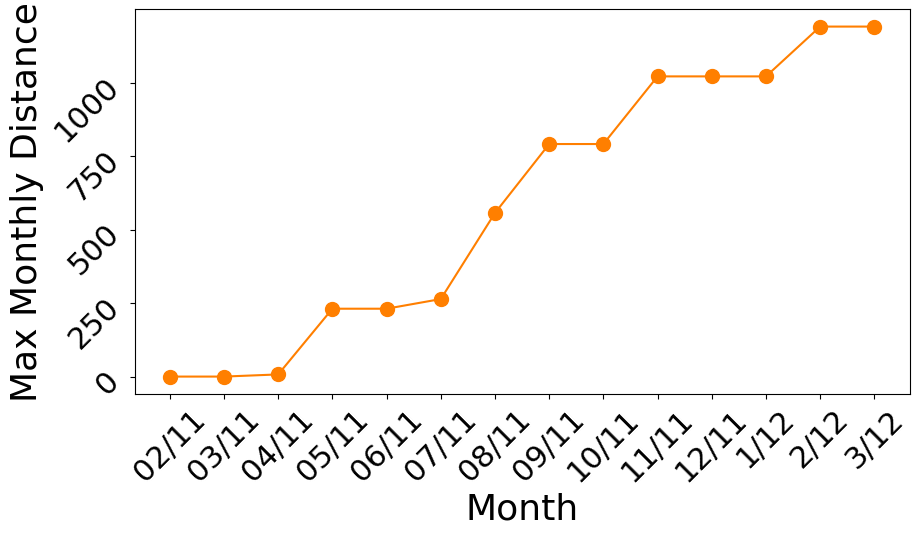

In [14]:
#f,axs = fig.subplots(1,3,figsize=(20,10))
fig,axs = plt.subplots(1,1,figsize=(10,5))
x_vals = [i for i in range(0,len(s_m))]
x_vals = ["02/11","03/11","04/11","05/11","06/11","07/11","08/11","09/11","10/11","11/11","12/11","1/12","2/12","3/12"]
print(len(x_vals))
ms = 100
axs.scatter(x_vals,s_d,color=colors[1],s=ms)
axs.plot(x_vals,s_d,color=colors[1])
axs.tick_params(labelsize=22,rotation=45)
axs.set_ylabel("Max Monthly Distance",size=26)
axs.set_xlabel("Month",size=26)
fig.savefig("figs/max_diameter.png",dpi=300, bbox_inches='tight')